#### This notebook tests the noise-corrected correlation formula on simulated crowding thresholds and reading speeds.
Created Jan 13, 2025  //  Last updated Mar 9, 2025

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, norm
import random
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

In [3]:
random.seed(42)

Below is data Helen sent on Feb 3 to inform mean crowding threshold and learning factor.

In [4]:
# # latest crowding means by block (log bouma)
# crowding_thresh = np.array([-0.426, -0.489, -0.525, -0.537, -0.563, -0.568])
# crowding_thresh_changes = np.array([np.abs(crowding_thresh[1] - crowding_thresh[0]), 
#                                     np.abs(crowding_thresh[2] - crowding_thresh[1]),
#                                     np.abs(crowding_thresh[3] - crowding_thresh[2]),
#                                     np.abs(crowding_thresh[4] - crowding_thresh[3]),
#                                     np.abs(crowding_thresh[5] - crowding_thresh[4])])
# plt.plot(np.arange(1,6), crowding_thresh_changes)
# plt.xlabel('start block', size=14)
# plt.ylabel('absolute change in log bouma', size=14)
# plt.title('Helen\'s data', size=16)

## Functions for simulations

In [5]:
class def_variable_parameters:
    
    def __init__(self, betweenVar, withinVar, mean, learning_factor):
        self.ObsVar = betweenVar
        self.MeasVar = withinVar
        self.Mean = mean
        self.learning_factor = learning_factor

In [6]:
def simulate_psychophysics_data(crowding_params, rsvp_params, n_samples=100, n_measurements=6, correlation = -0.7):
    '''
    Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
    for specified number of samples and measurements per sample for each task
    
    Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
    and the mean of those measurements for each "participant" (sample)
    
    # Parameters for the simulation
    The two required inputs are two objects, 
    each containing the parameters of the x and the y components of this correlation simulation.
     '''

    # Covariance matrix for the "true" thresholds
    cov_matrix = np.array([
        [crowding_params.ObsVar, correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar)],
        [correlation * np.sqrt(crowding_params.ObsVar * rsvp_params.ObsVar), rsvp_params.ObsVar]
    ])

    # Simulate "true" thresholds for crowding and RSVP reading
    true_thresholds = np.random.multivariate_normal(
        mean=[crowding_params.Mean, rsvp_params.Mean],
        cov=cov_matrix,
        size=n_samples
    )

    # Extract "true" values for crowding and RSVP
    true_crowding = true_thresholds[:, 0]
    true_rsvp = true_thresholds[:, 1]

    # Initialize a dictionary to store measurements
    data = {
        'crowding_true': true_crowding,
        'rsvp_true': true_rsvp,
    }

    # Simulate noisy measurements for both tasks in a single loop
    # Account for learning in crowding task 
    crowding_measurements = []
    rsvp_measurements = []
    for i in range(n_measurements):
        crowding_noise = np.random.normal(0, np.sqrt(crowding_params.MeasVar), size=n_samples)
        rsvp_noise = np.random.normal(0, np.sqrt(rsvp_params.MeasVar), size=n_samples)
        
        # Calculate noisy measurements 
        crowding_measurement = true_crowding + crowding_noise
        rsvp_measurement = true_rsvp + rsvp_noise
        
        # Increase initial crowding thresholds by learning factor (since learning hasn't yet occurred)
        if i == 0:
            crowding_measurement += 2 * crowding_params.learning_factor
        if i == 1:
            crowding_measurement += crowding_params.learning_factor

        # Add individual measurements to the dictionary
        data[f'crowding_measurement{i+1}'] = crowding_measurement
        data[f'rsvp_measurement{i+1}'] = rsvp_measurement

        # Collect measurements for later averaging
        crowding_measurements.append(crowding_measurement)
        rsvp_measurements.append(rsvp_measurement)

    # Compute the averages of all measurements
    data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
    data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

    # Create and return the DataFrame
    simulation_data = pd.DataFrame(data)
    return simulation_data

In [7]:
# test codes for updated function
# simulate_psychophysics_data(crowding_param, rsvp_param, n_samples=100, n_measurements=6, correlation = -0.7)


In [8]:
# simulation_data = simulate_psychophysics_data(n_samples=100, n_measurements=6)
# simulation_data = simulation_data[sorted(simulation_data.columns)]
# simulation_data.head()

In [9]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 10))
# # Scatter plot
# ax.scatter(x, y, alpha=0.7)

# # Regression line
# # UPDATE TO MINIMIZE PRODUCT OF X AND Y RESIDUALS
# slope, intercept = np.polyfit(x, y, 1)
# x_vals = np.linspace(min(x), max(x), 100)
# y_vals = slope * x_vals + intercept
# ax.plot(x_vals, y_vals, color='red', linestyle='dashed', label='Trend line')

# # Pearson correlation
# r, _ = stats.pearsonr(x, y)
# ax.text(0.05, 1.05, f'Pearson r = {r:.2f}', transform=ax.transAxes, fontsize=14, color='red')

# # Labels and title
# ax.set_xlabel(x_name, fontsize=14)
# ax.set_ylabel(y_name, fontsize=14)
# if title:
#     ax.set_title(title)

In [10]:
# bin_width = 0.05

# plt.figure(figsize=(8, 6))
# plt.hist(simulation_data['crowding_true'], 
#          bins=np.arange(min(simulation_data['crowding_true']), 
#                         max(simulation_data['crowding_true']) + bin_width, bin_width), 
#          color='blue', alpha=0.6, label='ground truth', edgecolor='black')
# plt.hist(simulation_data['crowding_measurement1'], 
#          bins=np.arange(min(simulation_data['crowding_measurement1']), 
#                         max(simulation_data['crowding_measurement1']) + bin_width, bin_width), 
#          color='green', alpha=0.6, label='measured', edgecolor='black')
# plt.xlabel('crowding threshold (log Bouma)')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

In [11]:
# mean_across_participants = np.array(np.mean(simulation_data, axis = 0))

# plt.plot(np.arange(1,7), mean_across_participants[1:7])
# plt.xlabel('block', size=14)
# plt.ylabel('log bouma', size=14)
# plt.title('simulated', size=16)

## Functions for noise-correction

In [12]:
def compute_variances(data):
    '''
    takes in n x m dataframe representing n participants and m thresholds (log units)
    
    returns within-participant and across-participant variances
    '''
    
    # Noise: variance within individuals
    within_indiv_var = np.mean(np.var(data, axis = 1, ddof=1))

    # Signal: variance across individuals
    across_indiv_var = np.var(np.mean(data, axis = 1), ddof=1)
    
    return within_indiv_var, across_indiv_var

In [13]:
def compute_noise_ceiling(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    first_half = measurements.iloc[:, :n_measurements//2]
    last_half = measurements.iloc[:, n_measurements//2:]
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_firstLast, _ = pearsonr(np.mean(first_half, axis=1), np.mean(last_half, axis=1))
    r_oddEven, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Compute the split-half reliability as the geometric mean
    r_i = np.sqrt(r_firstLast * r_oddEven)

    # Apply the extrapolation formula for multiple measurements
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m


In [14]:
# # Jitter function to slightly shift x-values for better visibility
# def jitter(values, jitter_amount=0.05):
#     return values + np.random.uniform(-jitter_amount, jitter_amount, size=len(values))

Below we run the simulation 1,000 times for each combo of specified sample sizes and number of measurements. For each round we get the mean difference between the ground truth corr and the corrected corr (using Diedrichsen's noise ceiling method). Then we can plot resulting histograms.

In [15]:
def run_simulation(crowding_param, rsvp_param,
                   range_samples=[40, 80, 160, 320], range_measurements=[2, 4, 8, 16], n_repetitions=1000,
                   true_correlation = -0.6):   

    # Store results
    hist_corrected_corr = {}
    hist_measured_corr = {}
    results_corr = []

    for n_samples in range_samples:
        for n_meas in range_measurements:
            diff_list_measured = []
            diff_list_corrected = []

            for _ in range(n_repetitions):
                simulation_data = simulate_psychophysics_data(crowding_param, rsvp_param,
                                                              n_samples, n_meas, correlation = true_correlation)

                crowding_measurements = simulation_data[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
                rsvp_measurements = simulation_data[[f'rsvp_measurement{i+1}' for i in range(n_meas)]]

                r_ceil_crowding = compute_noise_ceiling(crowding_measurements)
                r_ceil_rsvp = compute_noise_ceiling(rsvp_measurements)

                r_ceil = np.sqrt(r_ceil_crowding * r_ceil_rsvp)

                measured_corr, _ = pearsonr(simulation_data['crowding_measurement'], simulation_data['rsvp_measurement'])
                corrected_corr = measured_corr / r_ceil

                diff_list_measured.append(measured_corr - true_correlation)
                diff_list_corrected.append(corrected_corr - true_correlation)

            hist_measured_corr[(n_samples, n_meas)] = diff_list_measured
            hist_corrected_corr[(n_samples, n_meas)] = diff_list_corrected

            rmse_measured = np.sqrt(np.mean([x**2 for x in diff_list_measured])) 
            rmse_corrected = np.sqrt(np.mean([x**2 for x in diff_list_corrected]))

            mean_diff_measured = np.mean(diff_list_measured)
            mean_diff_corrected = np.mean(diff_list_corrected)

            sd_measured = np.std(diff_list_measured)
            sd_corrected = np.std(diff_list_corrected)

            ci_lower_measured, ci_upper_measured = norm.interval(0.95, loc=mean_diff_measured, 
                                                                 scale=np.std(diff_list_measured) / np.sqrt(n_repetitions))
            ci_lower_corrected, ci_upper_corrected = norm.interval(0.95, loc=mean_diff_corrected, 
                                                                   scale=np.std(diff_list_corrected) / np.sqrt(n_repetitions))

            results_corr.append({
                "n_samples": n_samples,
                "n_measurements": n_meas,

                "meanDiff_measured": mean_diff_measured,
                "rmse_measured": rmse_measured,
                "sd_measured": sd_measured,
                "ciLower_measured": ci_lower_measured,
                "ciUpper_measured": ci_upper_measured,

                "meanDiff_corrected": mean_diff_corrected,
                "rmse_corrected": rmse_corrected,
                "sd_corrected": sd_corrected,
                "ciLower_corrected": ci_lower_corrected,
                "ciUpper_corrected": ci_upper_corrected
            })

        print("done with n_samples =",n_samples)

    results_corr_df = pd.DataFrame(results_corr)
   
    return results_corr_df, hist_measured_corr, hist_corrected_corr 

## Functions for plotting the results

In [16]:
def plot_uncorrected_corrected(results_corr_df, x_values, x_subset_name, line_values, line_subset_name, line_label,
                              y_measured_name, y_corrected_name, 
                              x_label, y_label, colors):

    '''
    Inputs:
    - results_corr_df: data frame containing n_samples, n_measurements, and results 
                       such as rmse and sd associated with each number of samples/measurements
    - x_labels:        lists out what we are plotting on the x axis (e.g., n_samples, n_measurements);
    
    '''
    
    plt.figure(figsize=(10, 6))

    for i, ll in enumerate(line_values):
        subset = results_corr_df[results_corr_df[line_subset_name] == ll]

        color = colors[i]
        plt.errorbar(subset[x_subset_name], subset[y_measured_name],
                     fmt='-o', color=color, label=f"{ll} (Uncorrected)")
        plt.errorbar(subset[x_subset_name], subset[y_corrected_name],
                     fmt='--o', color=color, label=f"{ll} (Corrected)")

    plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
    plt.ylim(-.02,0.25)
    plt.yticks(size=14)
    plt.xlabel(x_label, size=18)
    plt.ylabel(y_label, size=18)
    plt.xscale('log')
    plt.xticks(x_values, labels=x_values, size=14)
    plt.gca().xaxis.set_minor_locator(plt.NullLocator())

    # Keep only one legend entry per sample size
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
    unique_handles = [handles[labels.index(label)] for label in unique_labels]

    plt.legend(unique_handles, unique_labels, title=line_label, bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

    plt.tight_layout()
    plt.show()

In [17]:
def plot_sim_results(results_corr):

    results_corr_df = results_corr[0]
    sample_sizes = sorted(results_corr_df["n_samples"].unique())
    colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))  # Use colormap for distinct colors
    n_measurements = sorted(results_corr_df["n_measurements"].unique())

    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'rmse_measured', 'rmse_corrected', 
                                  'Number of measurements', 'RMSE', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'rmse_measured', 'rmse_corrected', 
                                  'Number of samples', 'RMSE', colors)


    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'meanDiff_measured', 'meanDiff_corrected', 
                                  'Number of measurements', 'Mean difference', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'meanDiff_measured', 'meanDiff_corrected', 
                                  'Number of samples', 'Mean difference', colors)

    plot_uncorrected_corrected(results_corr_df, n_measurements, 'n_measurements', sample_sizes,'n_samples','Sample size',
                                  'sd_measured', 'sd_corrected', 
                                  'Number of measurements', 'SD', colors)


    plot_uncorrected_corrected(results_corr_df, sample_sizes, 'n_samples', n_measurements, 'n_measurements','Num measurements',
                                  'sd_measured', 'sd_corrected', 
                                  'Number of samples', 'SD', colors)

In [18]:
# # test codes
# crowding_param = def_variable_parameters(betweenVar=0.022, withinVar=0.012, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

## Simulate and plot with different values for variances

- Change between-variance for 1 variable
- Change within-variance for 1 variable

In [19]:
# # high between-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.044, withinVar=0.012, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

In [20]:
# # low between-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.011, withinVar=0.012, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

In [21]:
# # high within-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.022, withinVar=0.024, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

In [22]:
# # low within-individual variance for crowding
# crowding_param = def_variable_parameters(betweenVar=0.022, withinVar=0.003, mean=-0.426,learning_factor=0.06)
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)
# results_corr_df = run_simulation(crowding_param, rsvp_param)
# plot_sim_results(results_corr_df)

In [23]:
# # Histograms – MEASURED
# for (n_samples, n_measurements), differences in hist_measured_corr.items():
#     mean_diff = np.mean(differences)
#     sd = np.std(differences)

#     plt.figure(figsize=(5, 4))
#     plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')
#     plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
#     plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
#     plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
#     plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#     plt.xlim(-.6,.6)
#     plt.xlabel("Difference: Uncorrected-Sample R – Population R")
#     plt.ylabel("Frequency")
#     plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
#     plt.legend()
#     plt.show()

In [24]:
# # Histograms – CORRECTED
# for (n_samples, n_measurements), differences in hist_corrected_corr.items():
#     mean_diff = np.mean(differences)
#     sd = np.std(differences)

#     plt.figure(figsize=(5, 4))
#     plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')
#     plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
#     plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
#     plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
#     plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
#     plt.xlim(-.6,.6)
#     plt.xlabel("Difference: Corrected-Sample R – Population R")
#     plt.ylabel("Frequency")
#     plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
#     plt.legend()
#     plt.show()

## Vary within- & between-individual variances

I am interested in how the within- and between-individual variances change the measured correlations, given the same number of samples and number of measurements per sample.

I am also curious about whether the measured correlations only depends on the ratio, but not the absolute values of the within- and between-individual variances. Therefore, I want to plot a 5-by-5 chart of RMSEs, with different values for the variances.

In [25]:
import math

def round_up(x, decimals=2):
    factor = 10 ** decimals
    return math.ceil(x * factor) / factor

In [26]:
def plot_matrix(mtx, fig_specs, n_vars):

    # Define minimum and maximum values on the color scale
    min_data = mtx.min() if fig_specs.cval_min is None else fig_specs.cval_min
    max_data = mtx.max() if fig_specs.cval_max is None else fig_specs.cval_max
    
    fig, ax = plt.subplots(figsize=(6, 6))
    norm = mcolors.LogNorm(vmin=min_data, vmax=max_data)
    cax = ax.matshow(mtx, cmap='coolwarm', norm=norm)

    
    # Generate logarithmically spaced color bar ticks
    cbar_ticks = []
    curr_dp = min_data
    while curr_dp <= max_data:
        cbar_ticks.append(round_up(curr_dp,2))
#         cbar_ticks.append(curr_dp)
        curr_dp *= 2  

    cbar = plt.colorbar(cax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_ticks)
    cbar.ax.yaxis.set_minor_locator(plt.NullLocator())

    # Display the values inside the matrix
    for i in range(n_vars):
        for j in range(n_vars):
            ax.text(j, i, f"{mtx[i, j]:.2f}", ha='center', va='center', color='black')

    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')
    ax.set_xticks(range(n_vars))
    ax.set_yticks(range(n_vars))
    ax.set_xticklabels(fig_specs.xticklabels)
    ax.set_yticklabels(fig_specs.yticklabels)
    ax.set_xlabel(fig_specs.x_label)
    ax.set_ylabel(fig_specs.y_label)
    ax.set_title(fig_specs.title)

    plt.show()

In [27]:
class def_plot_labels:
    
    def __init__(self, title="", x_label="", y_label="", xticklabels=None, yticklabels=None,
                cval_min = None, cval_max = None):
        self.title = title
        self.x_label = x_label
        self.y_label = y_label
        self.xticklabels = xticklabels if xticklabels is not None and len(xticklabels) > 0 else []
        self.yticklabels = yticklabels if yticklabels is not None and len(yticklabels) > 0 else []
        self.cval_min = cval_min if cval_min else None
        self.cval_max = cval_max if cval_max else None

In [28]:
# # Define parameters
# n_vars = 5
# min_between = 0.01

# # Generate between and within variance arrays
# between_vars = np.array([min_between * (2 ** ii) for ii in range(n_vars)])
# within_vars = np.array([min_between * (2 ** ii) for ii in range(n_vars)])

# # Initialize matrices
# btw = np.full((n_vars, n_vars), np.nan)
# within = np.full((n_vars, n_vars), np.nan)
# ratio_btwVwithin = np.full((n_vars, n_vars), np.nan)

# # Compute matrices
# for ii in range(n_vars):
#     for jj in range(n_vars):
#         btw[ii, jj] = between_vars[jj]
#         within[ii, jj] = within_vars[ii]
#         ratio_btwVwithin[ii, jj] = between_vars[jj] / within_vars[ii]
        
# ratio_plot_labels = def_plot_labels(title = 'Ratio of between and within variances', 
#                                     x_label = 'Between variance',
#                                     y_label = 'Within variance',
#                                     xticklabels = [f"{bv:.2f}" for bv in between_vars],
#                                     yticklabels = [f"{wv:.2f}" for wv in within_vars])

# plot_matrix(ratio_btwVwithin, ratio_plot_labels, n_vars)

In [29]:
# # repeat the simulation, change the between and within variances of crowding
# # RSVP parameters are kept the same
# rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)

# rmse_measured_mtx = np.full((n_vars, n_vars), np.nan)
# rmse_corrected_mtx = np.full((n_vars, n_vars), np.nan)
# sd_measured_mtx = np.full((n_vars, n_vars), np.nan)
# sd_corrected_mtx = np.full((n_vars, n_vars), np.nan)
# meandiff_measured_mtx = np.full((n_vars, n_vars), np.nan)
# meandiff_corrected_mtx = np.full((n_vars, n_vars), np.nan)

# for ii in range(n_vars):
#     for jj in range(n_vars):
#         between_var = between_vars[jj]
#         within_var = within_vars[ii]
#         crowding_param = def_variable_parameters(betweenVar=between_var, withinVar=within_var,
#                                                  mean=-0.426,learning_factor=0.06)
        
#         results_corr = run_simulation(crowding_param, rsvp_param, range_samples=[320], range_measurements=[2])
#         results_corr_df = results_corr[0]
#         rmse_measured_mtx[ii, jj] = results_corr_df['rmse_measured'].iloc[0]
#         rmse_corrected_mtx[ii, jj] = results_corr_df['rmse_corrected'].iloc[0]

#         sd_measured_mtx[ii, jj] = results_corr_df['sd_measured'].iloc[0]
#         sd_corrected_mtx[ii, jj] = results_corr_df['sd_corrected'].iloc[0]
        
#         meandiff_measured_mtx[ii, jj] = results_corr_df['meanDiff_measured'].iloc[0]
#         meandiff_corrected_mtx[ii, jj] = results_corr_df['meanDiff_corrected'].iloc[0]

In [30]:
# measured_plot_labels = def_plot_labels(title = 'RMSE of measured correlation', 
#                                         x_label = 'Between variance',
#                                         y_label = 'Within variance',
#                                         xticklabels = [f"{bv:.2f}" for bv in between_vars],
#                                         yticklabels = [f"{wv:.2f}" for wv in within_vars],
#                                         cval_min = 0.01,
#                                         cval_max = 1.1)

# plot_matrix(rmse_measured_mtx, measured_plot_labels, n_vars)

In [31]:
# corrected_plot_labels = def_plot_labels(title = 'RMSE of corrected correlation', 
#                                     x_label = 'Between variance',
#                                     y_label = 'Within variance',
#                                     xticklabels = [f"{bv:.2f}" for bv in between_vars],
#                                     yticklabels = [f"{wv:.2f}" for wv in within_vars],
#                                     cval_min = 0.01,
#                                     cval_max = 1.1)


# plot_matrix(rmse_corrected_mtx, corrected_plot_labels, n_vars)

In [32]:
# measured_sd_plot_labels = def_plot_labels(title = 'SD of measured correlation', 
#                                                     x_label = 'Between variance',
#                                                     y_label = 'Within variance',
#                                                     xticklabels = [f"{bv:.2f}" for bv in between_vars],
#                                                     yticklabels = [f"{wv:.2f}" for wv in within_vars],
#                                                     cval_min = 0.01,
#                                                     cval_max = 1.1
#                                                     )

# plot_matrix(sd_measured_mtx, measured_sd_plot_labels, n_vars)

In [33]:
# corrected_sd_plot_labels = def_plot_labels(title = 'SD of corrected correlation', 
#                                                     x_label = 'Between variance',
#                                                     y_label = 'Within variance',
#                                                     xticklabels = [f"{bv:.2f}" for bv in between_vars],
#                                                     yticklabels = [f"{wv:.2f}" for wv in within_vars],
#                                                     cval_min = 0.01,
#                                                     cval_max = 1.1
#                                                     )

# plot_matrix(sd_corrected_mtx, corrected_sd_plot_labels, n_vars)

In [34]:
# measured_md_plot_labels = def_plot_labels(title = 'Mean difference of measured correlation', 
#                                                     x_label = 'Between variance',
#                                                     y_label = 'Within variance',
#                                                     xticklabels = [f"{bv:.2f}" for bv in between_vars],
#                                                     yticklabels = [f"{wv:.2f}" for wv in within_vars],
#                                                     cval_min = 0.01,
#                                                     cval_max = 1.1
#                                                     )

# plot_matrix(meandiff_measured_mtx, measured_md_plot_labels, n_vars)

In [35]:
# corrected_md_plot_labels = def_plot_labels(title = 'Mean difference of corrected correlation', 
#                                                     x_label = 'Between variance',
#                                                     y_label = 'Within variance',
#                                                     xticklabels = [f"{bv:.2f}" for bv in between_vars],
#                                                     yticklabels = [f"{wv:.2f}" for wv in within_vars],
#                                                     cval_min = 0.01,
#                                                     cval_max = 1.1
#                                                     )

# plot_matrix(meandiff_corrected_mtx, corrected_md_plot_labels, n_vars)


## Vary the SNR (between- / within-individual variances) for one variable

The matrix plots above shows that when between-/within-individual variance, but not the values of the variances, determine the errors of the predicted correlations.
Below, I plot the simulation results as a function of SNR.

In [36]:
n_ratios = 7
min_ratio = 0.125
ratios = np.array([min_ratio * (2 ** ii) for ii in range(n_ratios)])
print(f'ratios: {ratios}')

within_vars = 0.2 #np.full(n_ratios, 0.2)
between_vars = ratios * within_vars

print(f'within-individual variance: {within_vars}')
print(f'between-individual variances: {between_vars}')

ratios: [0.125 0.25  0.5   1.    2.    4.    8.   ]
within-individual variance: 0.2
between-individual variances: [0.025 0.05  0.1   0.2   0.4   0.8   1.6  ]


In [37]:
# repeat the simulation, change the between and within variances of crowding
# RSVP parameters are kept the same
rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)

rmse_measured_mtx = np.full(n_ratios, np.nan)
rmse_corrected_mtx = np.full(n_ratios, np.nan)
sd_measured_mtx = np.full(n_ratios, np.nan)
sd_corrected_mtx = np.full(n_ratios, np.nan)
meandiff_measured_mtx = np.full(n_ratios, np.nan)
meandiff_corrected_mtx = np.full(n_ratios, np.nan)

for ii in range(n_ratios):
    
    between_var = between_vars[ii]
    crowding_param = def_variable_parameters(betweenVar=between_var, withinVar=within_vars,
                                             mean=-0.426,learning_factor=0.06)

    results_corr = run_simulation(crowding_param, rsvp_param, range_samples=[320], range_measurements=[2])
    results_corr_df = results_corr[0]

    rmse_measured_mtx[ii] = results_corr_df['rmse_measured'].iloc[0]
    rmse_corrected_mtx[ii] = results_corr_df['rmse_corrected'].iloc[0]

    sd_measured_mtx[ii] = results_corr_df['sd_measured'].iloc[0]
    sd_corrected_mtx[ii] = results_corr_df['sd_corrected'].iloc[0]

    meandiff_measured_mtx[ii] = results_corr_df['meanDiff_measured'].iloc[0]
    meandiff_corrected_mtx[ii] = results_corr_df['meanDiff_corrected'].iloc[0]

done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320


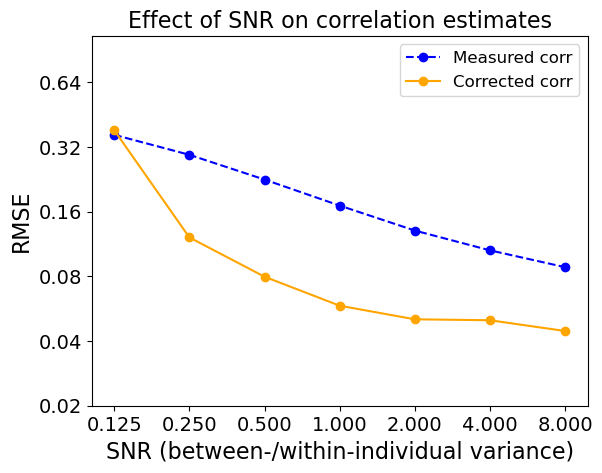

In [38]:
plt.figure()
plt.plot(ratios,rmse_measured_mtx, 'o--', color='blue', label='Measured corr')
plt.plot(ratios,rmse_corrected_mtx, 'o-', color='orange', label='Corrected corr')

# Formatting
plt.title('Effect of SNR on correlation estimates', fontsize=16)
plt.legend(fontsize='large')

plt.xlabel('SNR (between-/within-individual variance)', fontsize=16)
plt.xscale('log')
plt.xticks(ratios, size=14)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('RMSE', fontsize=16)
plt.yscale('log')
ylims = [0.02, 1.05]
plt.ylim(ylims)
n_ticks = 6
y_ticks = np.array([ylims[0] * (2 ** ii) for ii in range(n_ticks)])
plt.yticks(y_ticks, size=14)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.show()

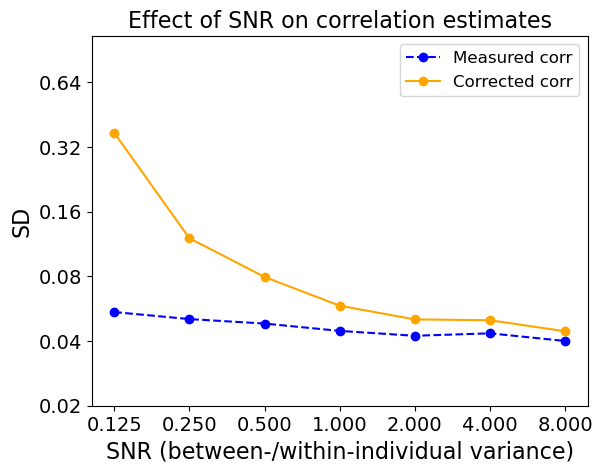

In [39]:
plt.figure()
plt.plot(ratios,sd_measured_mtx, 'o--', color='blue', label='Measured corr')
plt.plot(ratios,sd_corrected_mtx, 'o-', color='orange', label='Corrected corr')

# Formatting
plt.title('Effect of SNR on correlation estimates', fontsize=16)
plt.legend(fontsize='large')

plt.xlabel('SNR (between-/within-individual variance)', fontsize=16)
plt.xscale('log')
plt.xticks(ratios, size=14)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('SD', fontsize=16)
plt.yscale('log')
ylims = [0.02, 1.05]
plt.ylim(ylims)
n_ticks = 6
y_ticks = np.array([ylims[0] * (2 ** ii) for ii in range(n_ticks)])
plt.yticks(y_ticks, size=14)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.show()

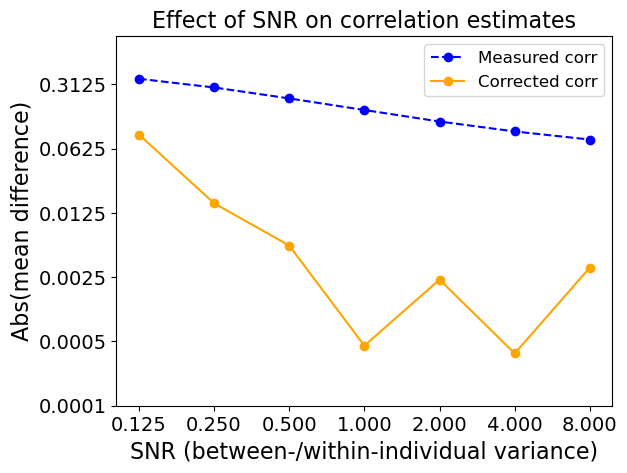

In [40]:
plt.figure()
plt.plot(ratios,abs(meandiff_measured_mtx), 'o--', color='blue', label='Measured corr')
plt.plot(ratios,abs(meandiff_corrected_mtx), 'o-', color='orange', label='Corrected corr')

# Formatting
plt.title('Effect of SNR on correlation estimates', fontsize=16)
plt.legend(fontsize='large')

plt.xlabel('SNR (between-/within-individual variance)', fontsize=16)
plt.xscale('log')
plt.xticks(ratios, size=14)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('Abs(mean difference)', fontsize=16)
plt.yscale('log')
ylims = [0.0001, 1.05]
plt.ylim(ylims)
n_ticks = 6
y_ticks = np.array([ylims[0] * (5 ** ii) for ii in range(n_ticks)])
plt.yticks(y_ticks, size=14)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.show()

## Vary the SNR for both crowding and reading

In the previous section, we varied the SNR for only one variable. Here, we will vary the SNR for each of the variable and see how it changes the results.

In [41]:
n_ratios = 7
min_ratio = 0.125
ratios = np.array([min_ratio * (2 ** ii) for ii in range(n_ratios)])
print(f'ratios: {ratios}')

within_vars = 0.2 
between_vars = ratios * within_vars

print(f'within-individual variance: {within_vars}')
print(f'between-individual variances: {between_vars}')

crowding_btw_var_mtx = np.full((n_ratios,n_ratios), np.nan)
reading_btw_var_mtx = np.full((n_ratios,n_ratios), np.nan)
rmse_measured_mtx = np.full((n_ratios,n_ratios), np.nan)
rmse_corrected_mtx = np.full((n_ratios,n_ratios), np.nan)
sd_measured_mtx = np.full((n_ratios,n_ratios), np.nan)
sd_corrected_mtx = np.full((n_ratios,n_ratios), np.nan)
meandiff_measured_mtx = np.full((n_ratios,n_ratios), np.nan)
meandiff_corrected_mtx = np.full((n_ratios,n_ratios), np.nan)

for ii in range(n_ratios):
    for jj in range (n_ratios): 
    
        between_var_crowding = between_vars[ii]
        between_var_reading = between_vars[jj]
       
        crowding_param = def_variable_parameters(betweenVar=between_var_crowding, withinVar=within_vars,
                                                 mean=-0.426,learning_factor=0.06)
        rsvp_param = def_variable_parameters(betweenVar=between_var_reading, withinVar=within_vars, 
                                             mean=2.96,learning_factor=0)
    
        results_corr = run_simulation(crowding_param, rsvp_param, range_samples=[320], range_measurements=[2])
        results_corr_df = results_corr[0]
    
        crowding_btw_var_mtx[ii,jj] = between_var_crowding
        reading_btw_var_mtx[ii,jj] = between_var_reading      
        
        rmse_measured_mtx[ii,jj] = results_corr_df['rmse_measured'].iloc[0]
        rmse_corrected_mtx[ii,jj] = results_corr_df['rmse_corrected'].iloc[0]
    
        sd_measured_mtx[ii,jj] = results_corr_df['sd_measured'].iloc[0]
        sd_corrected_mtx[ii,jj] = results_corr_df['sd_corrected'].iloc[0]
    
        meandiff_measured_mtx[ii,jj] = results_corr_df['meanDiff_measured'].iloc[0]
        meandiff_corrected_mtx[ii,jj] = results_corr_df['meanDiff_corrected'].iloc[0]

ratios: [0.125 0.25  0.5   1.    2.    4.    8.   ]
within-individual variance: 0.2
between-individual variances: [0.025 0.05  0.1   0.2   0.4   0.8   1.6  ]
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with n_samples = 320
done with 

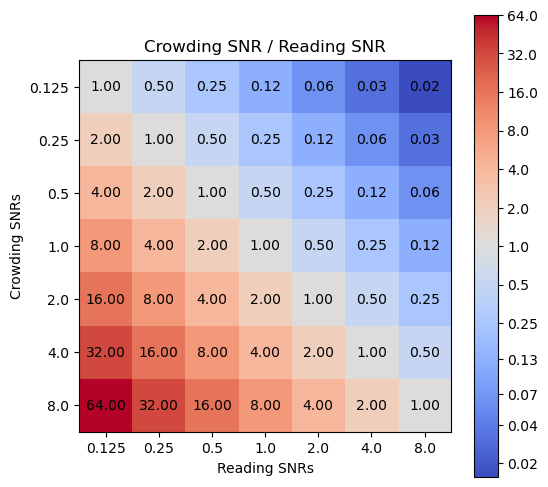

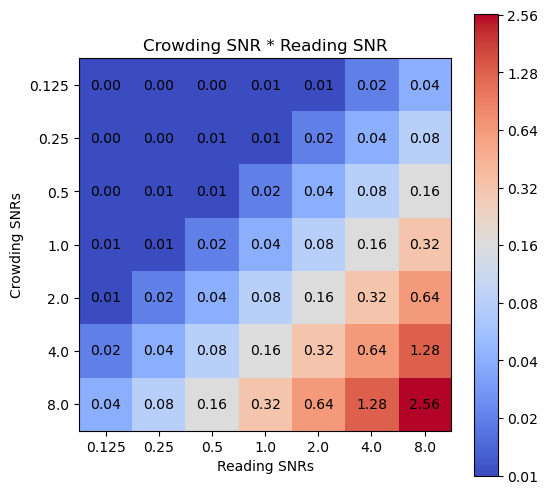

In [42]:
# crowdingSNR_plot_labels = def_plot_labels(title = 'Crowding SNRs')
# plot_matrix(crowding_btw_var_mtx/within_vars, crowdingSNR_plot_labels, n_ratios)

# readingSNR_plot_labels = def_plot_labels(title = 'Reading SNRs')
# plot_matrix(reading_btw_var_mtx/within_vars, readingSNR_plot_labels, n_ratios)

reading_label = reading_btw_var_mtx[0,:]/within_vars
crowding_label = crowding_btw_var_mtx[:,0]/within_vars
SNR_plot_labels = def_plot_labels(title = 'Crowding SNR / Reading SNR', 
                                    x_label = 'Reading SNRs',
                                    y_label = 'Crowding SNRs',
                                    xticklabels = reading_label,
                                    yticklabels = crowding_label)
plot_matrix(crowding_btw_var_mtx/reading_btw_var_mtx, SNR_plot_labels, n_ratios)

SNR_plot_labels = def_plot_labels(title = 'Crowding SNR * Reading SNR', 
                                    x_label = 'Reading SNRs',
                                    y_label = 'Crowding SNRs',
                                    xticklabels = reading_label,
                                    yticklabels = crowding_label,
                                    cval_min = 0.01, cval_max = 2.6)

plot_matrix(crowding_btw_var_mtx*reading_btw_var_mtx, SNR_plot_labels, n_ratios)

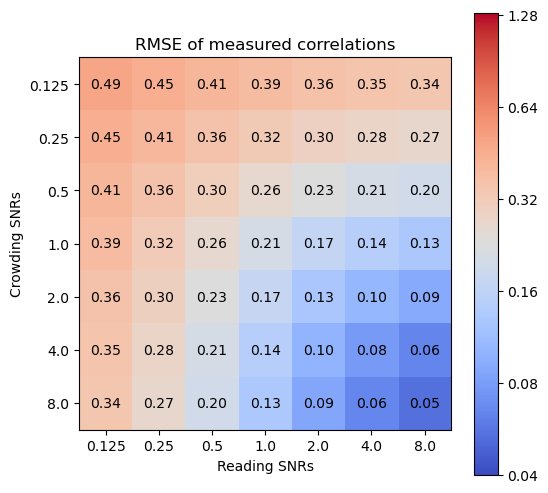

In [43]:
RMSE_measured_plot_labels = def_plot_labels(title = 'RMSE of measured correlations', 
                                            x_label = 'Reading SNRs',
                                            y_label = 'Crowding SNRs',
                                            xticklabels = reading_label,
                                            yticklabels = crowding_label,
                                            cval_min = 0.04, cval_max = 1.3)
plot_matrix(rmse_measured_mtx, RMSE_measured_plot_labels, n_ratios)

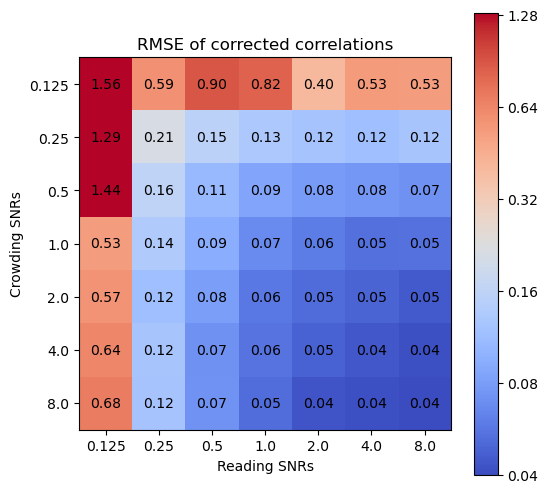

In [44]:
RMSE_corrected_plot_labels = def_plot_labels(title = 'RMSE of corrected correlations', 
                                    x_label = 'Reading SNRs',
                                    y_label = 'Crowding SNRs',
                                    xticklabels = reading_label,
                                    yticklabels = crowding_label,
                                    cval_min = 0.04, cval_max = 1.3)
plot_matrix(rmse_corrected_mtx, RMSE_corrected_plot_labels, n_ratios)

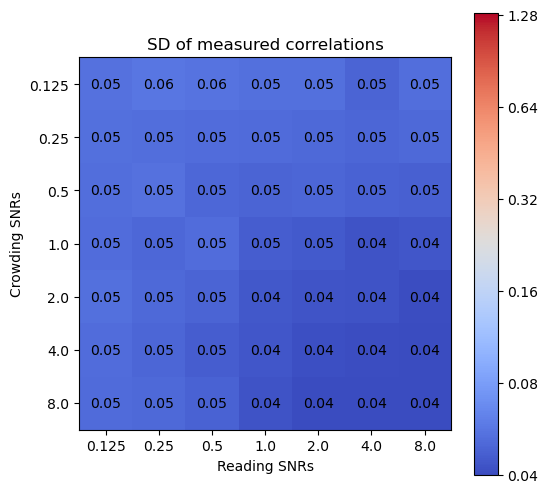

In [45]:
sd_measured_plot_labels = def_plot_labels(title = 'SD of measured correlations', 
                                    x_label = 'Reading SNRs',
                                    y_label = 'Crowding SNRs',
                                    xticklabels = reading_label,
                                    yticklabels = crowding_label,
                                    cval_min = 0.04, cval_max = 1.3)
plot_matrix(sd_measured_mtx, sd_measured_plot_labels, n_ratios)

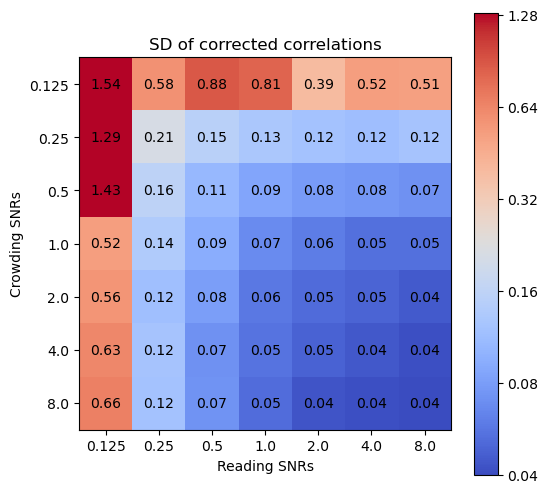

In [46]:
sd_corrected_plot_labels = def_plot_labels(title = 'SD of corrected correlations', 
                                    x_label = 'Reading SNRs',
                                    y_label = 'Crowding SNRs',
                                    xticklabels = reading_label,
                                    yticklabels = crowding_label,
                                    cval_min = 0.04, cval_max = 1.3)
plot_matrix(sd_corrected_mtx, sd_corrected_plot_labels, n_ratios)

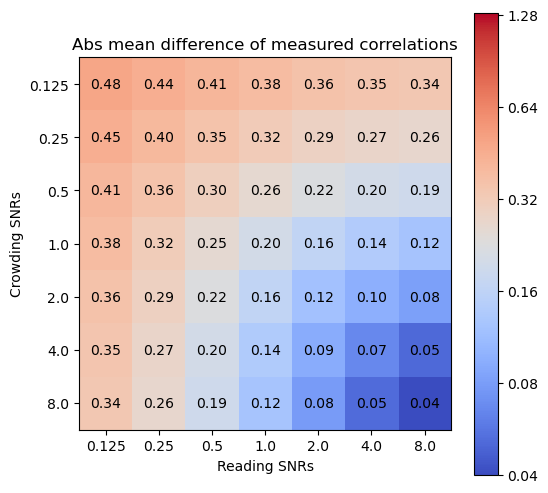

In [47]:
meandiff_measured_plot_labels = def_plot_labels(title = 'Abs mean difference of measured correlations', 
                                    x_label = 'Reading SNRs',
                                    y_label = 'Crowding SNRs',
                                    xticklabels = reading_label,
                                    yticklabels = crowding_label,
                                    cval_min = 0.04, cval_max = 1.3)

plot_matrix(abs(meandiff_measured_mtx), meandiff_measured_plot_labels, n_ratios)

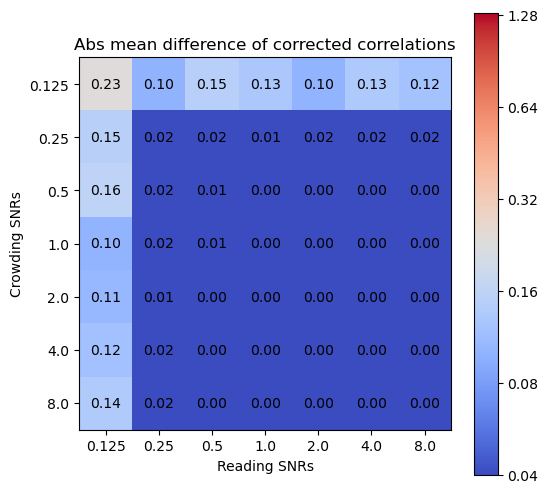

In [48]:
meandiff_corrected_plot_labels = def_plot_labels(title = 'Abs mean difference of corrected correlations', 
                                    x_label = 'Reading SNRs',
                                    y_label = 'Crowding SNRs',
                                    xticklabels = reading_label,
                                    yticklabels = crowding_label,
                                    cval_min = 0.04, cval_max = 1.3)

plot_matrix(abs(meandiff_corrected_mtx), meandiff_corrected_plot_labels, n_ratios)

## Vary population correlation

How does the population correlation affect variances?

In [49]:
n_rVals = 5
min_rVal = 0.06
rVals = np.array([min_rVal * (2 ** ii) for ii in range(n_rVals)]) * -1
print(f'rVals: {rVals}')

rVals: [-0.06 -0.12 -0.24 -0.48 -0.96]


done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


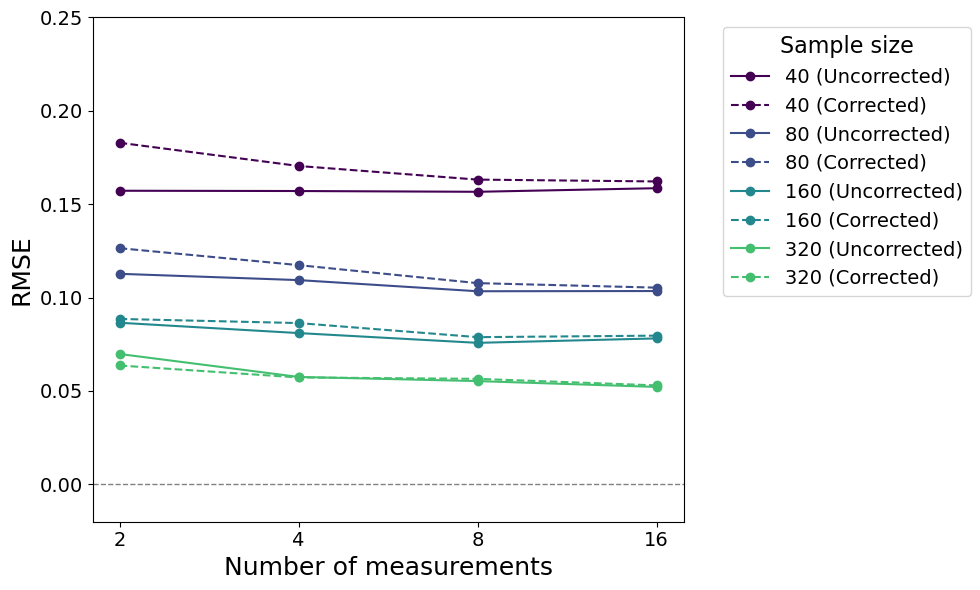

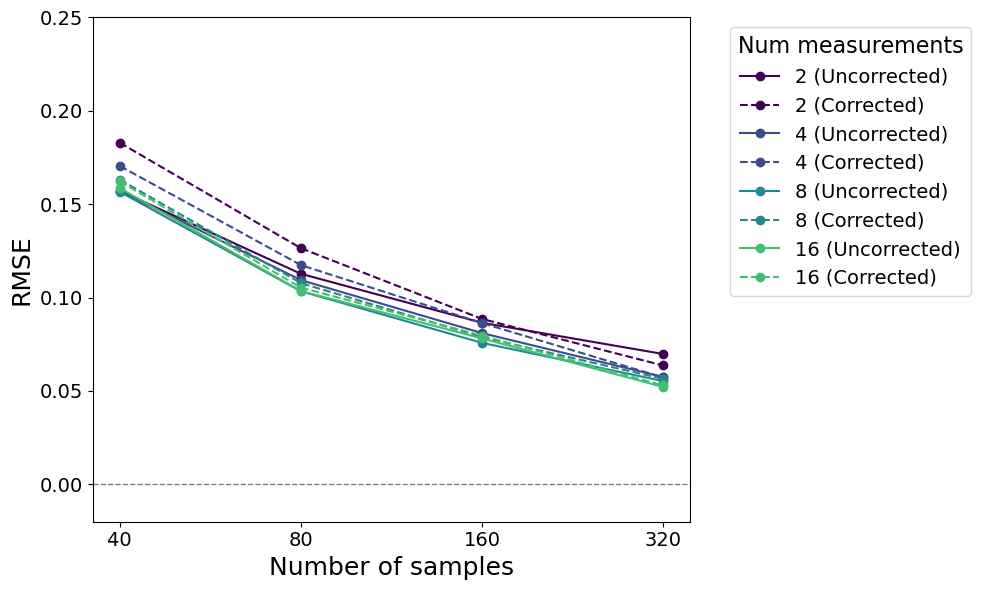

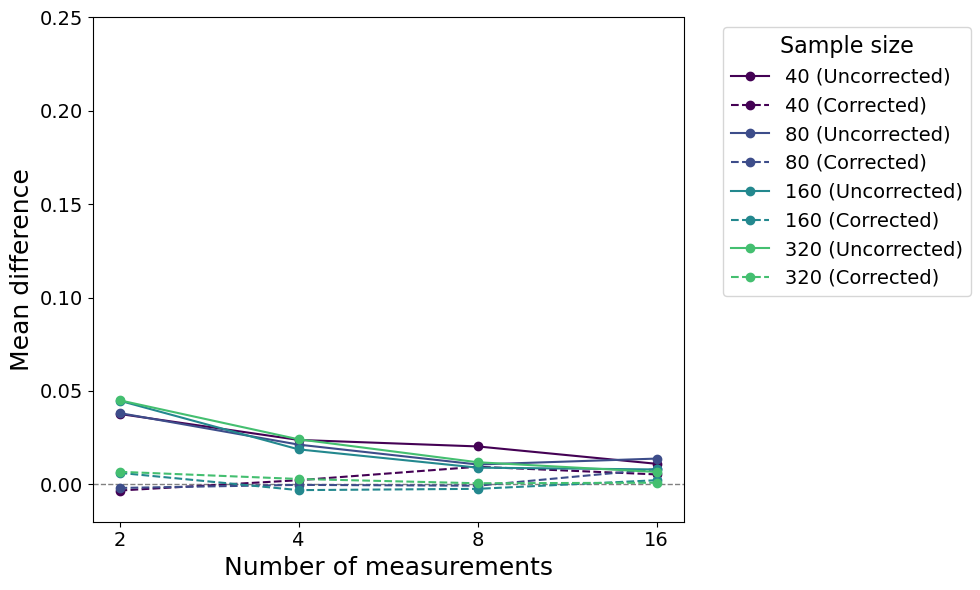

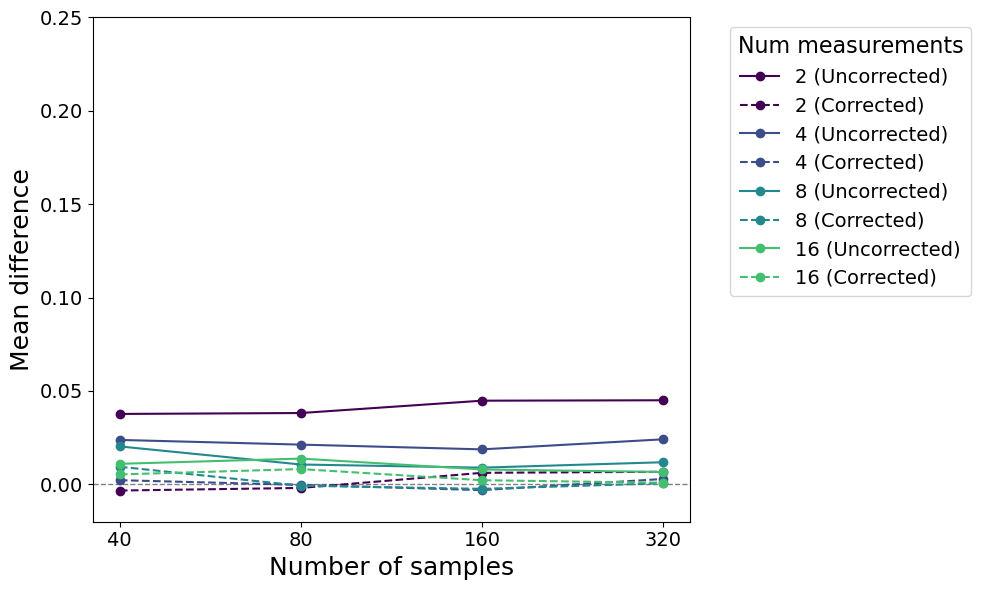

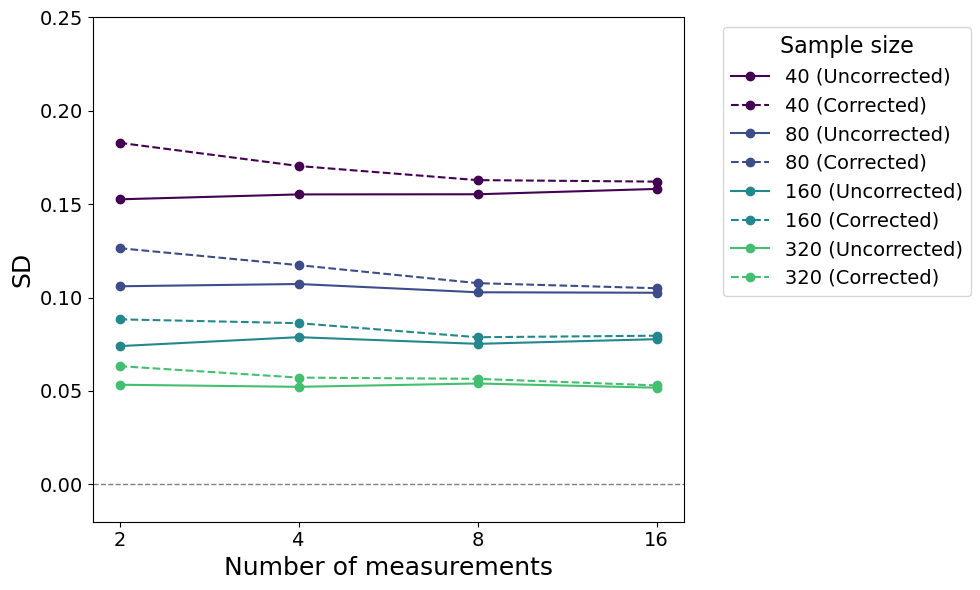

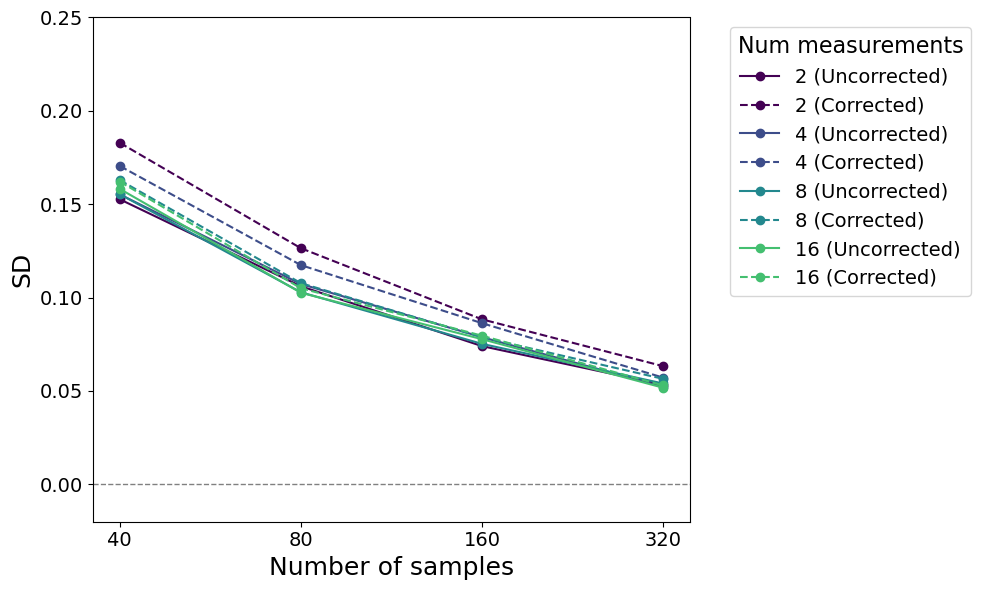

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


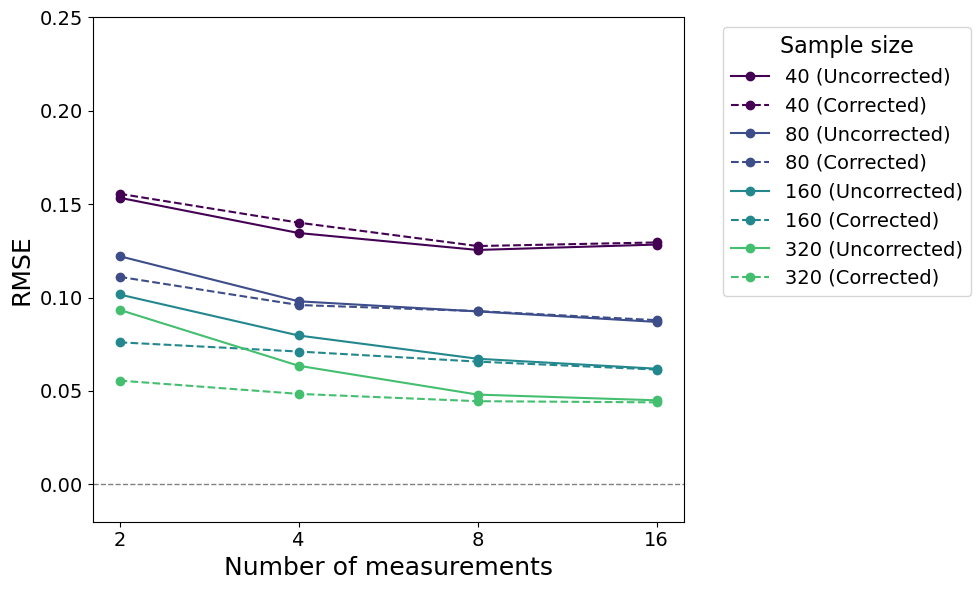

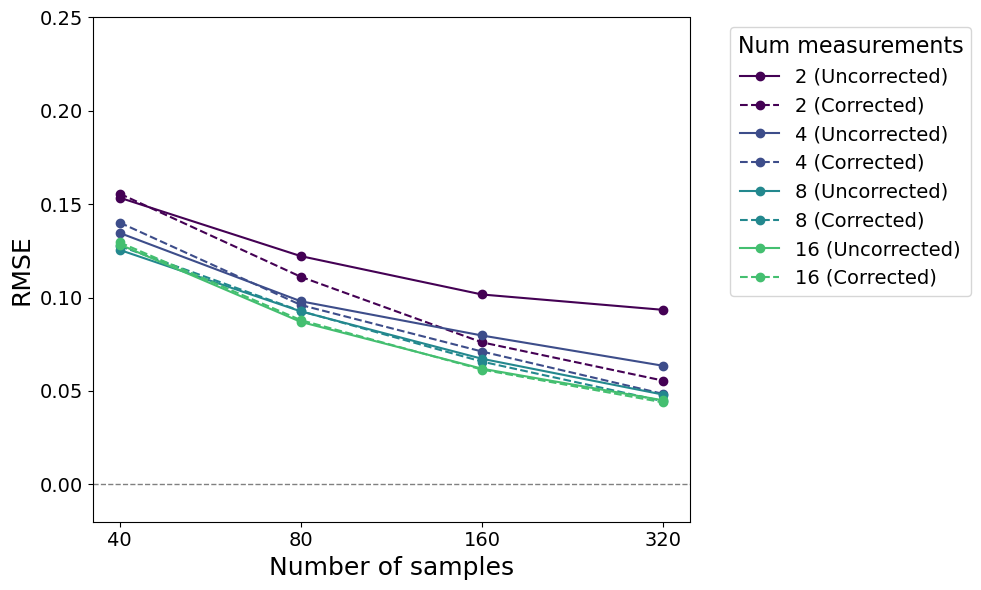

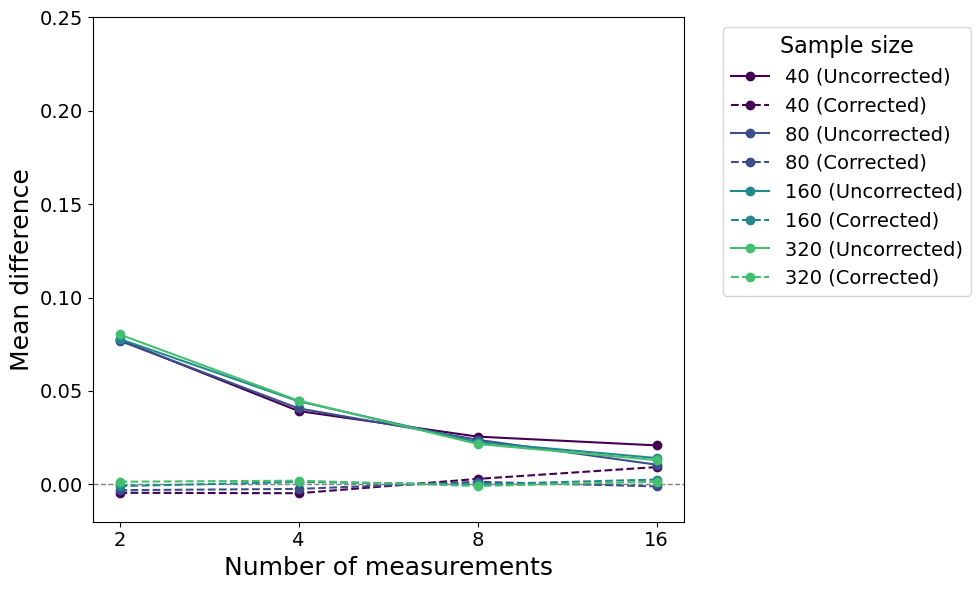

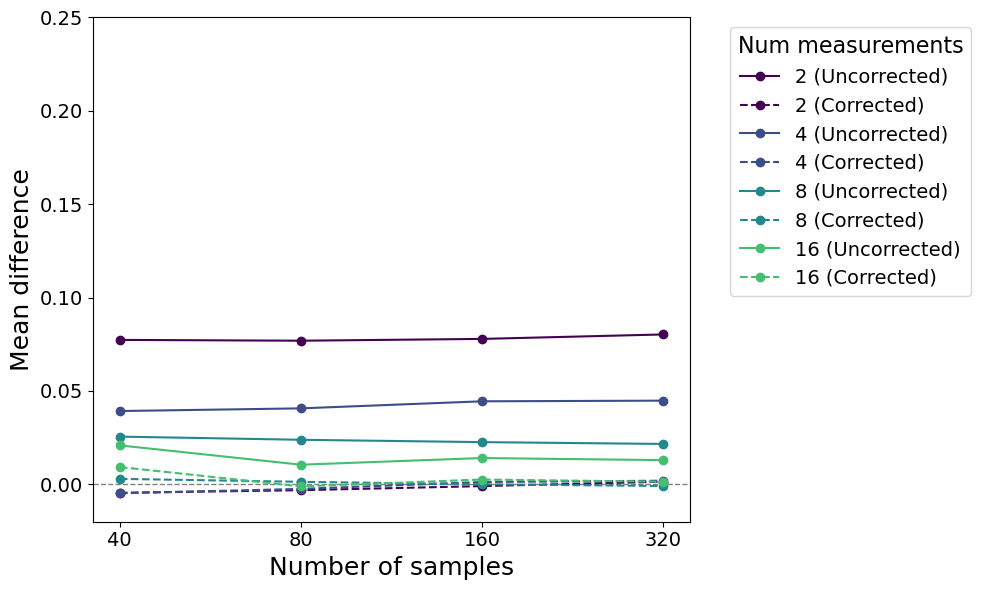

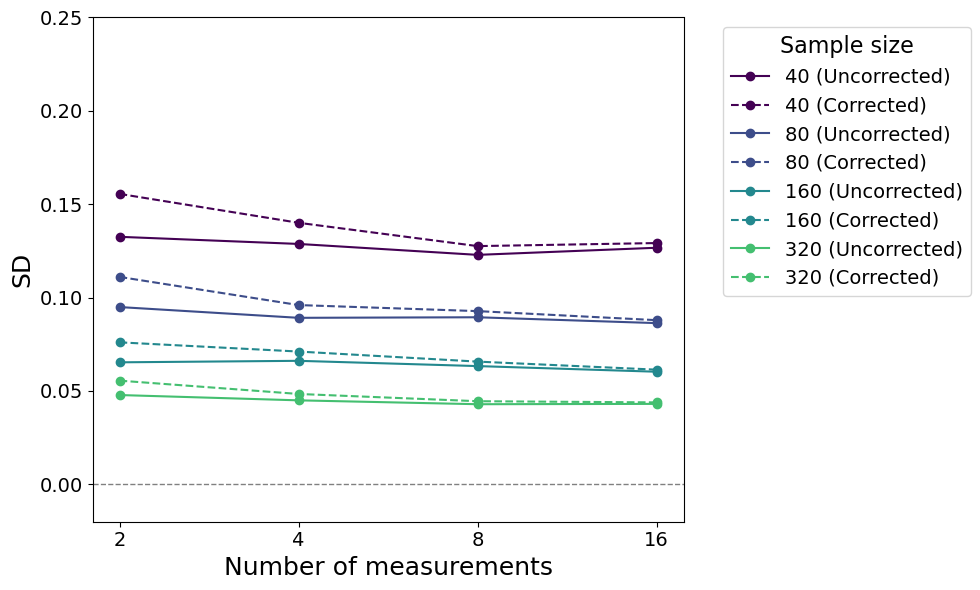

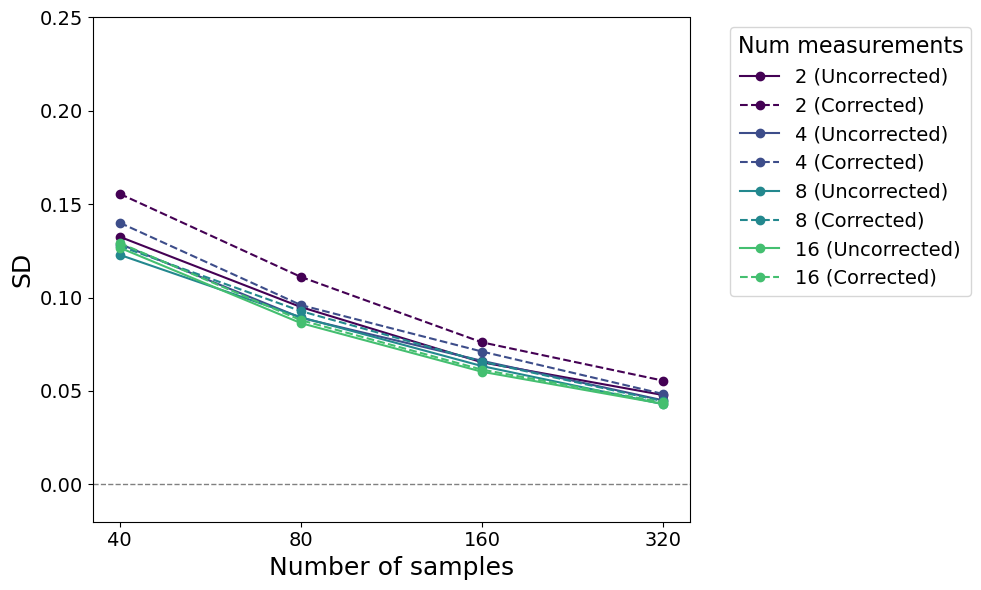

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


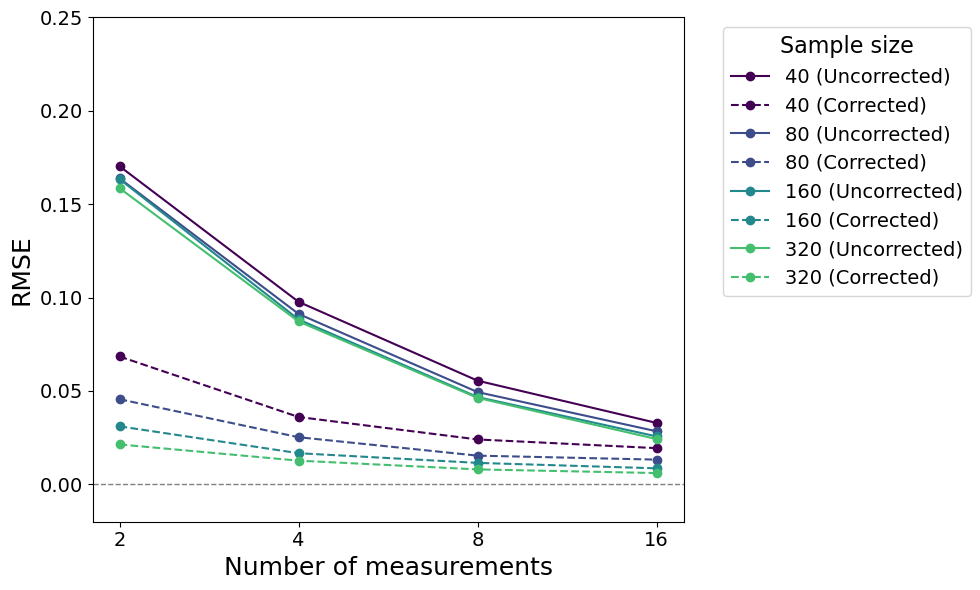

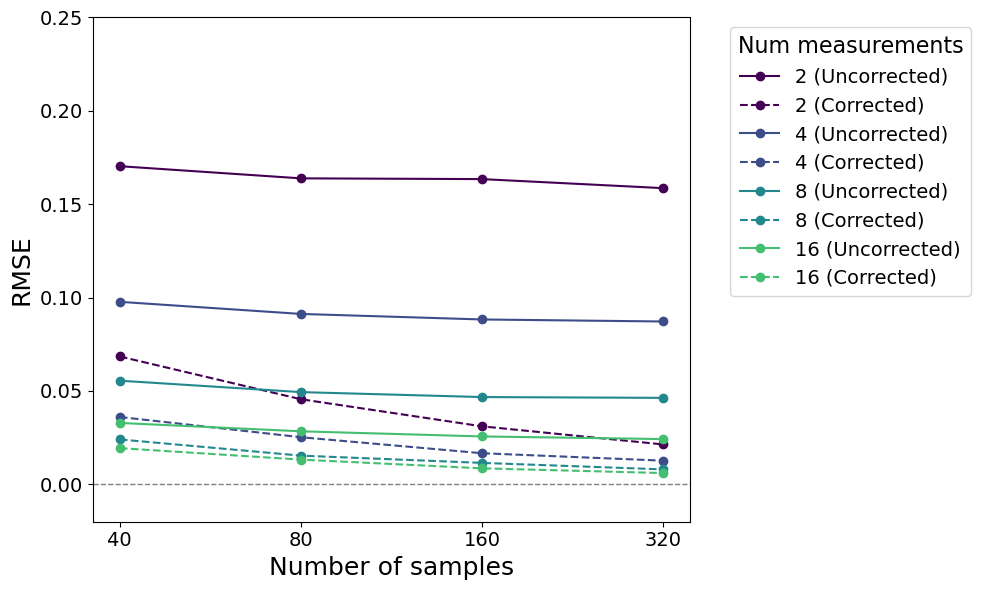

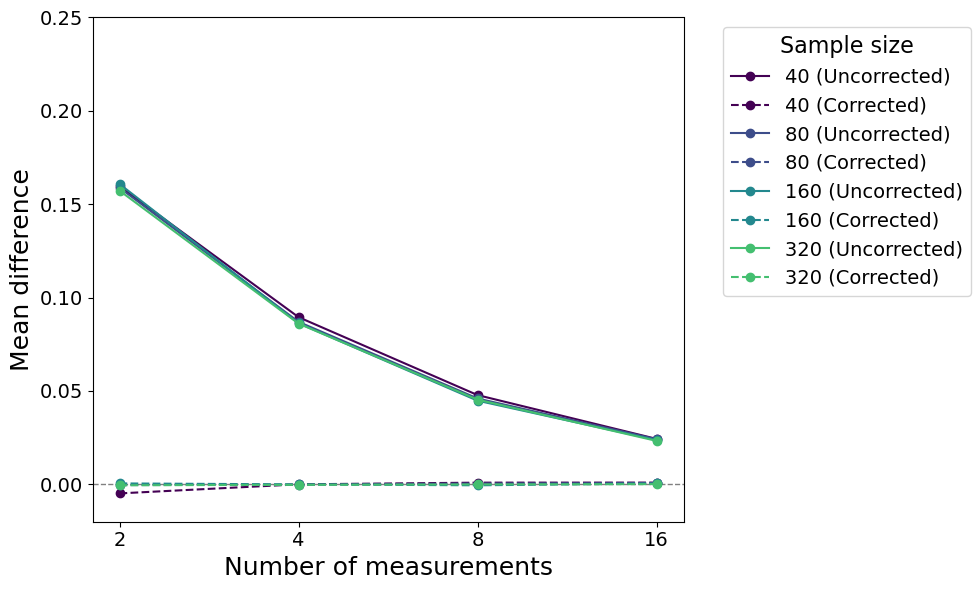

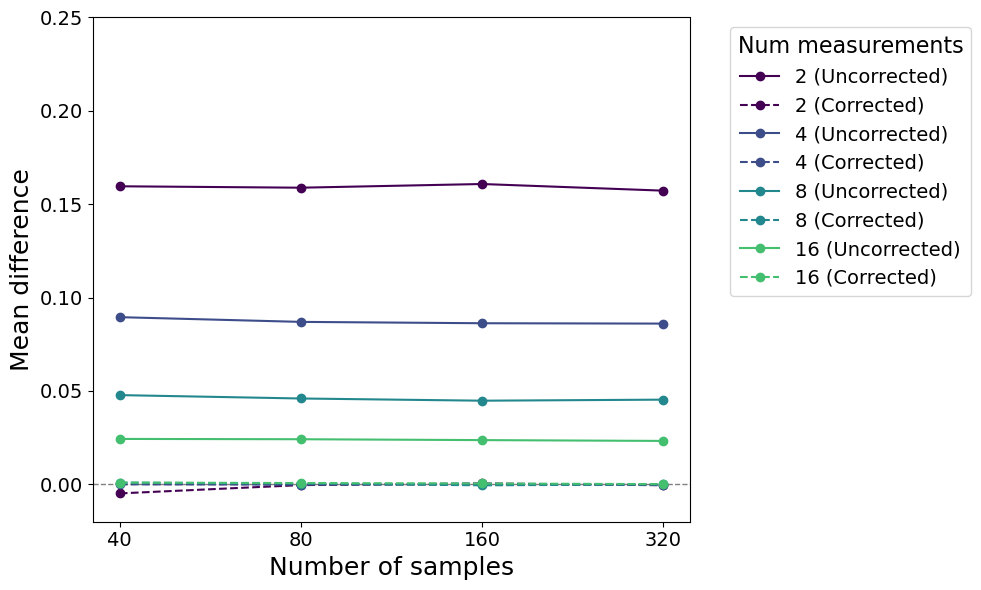

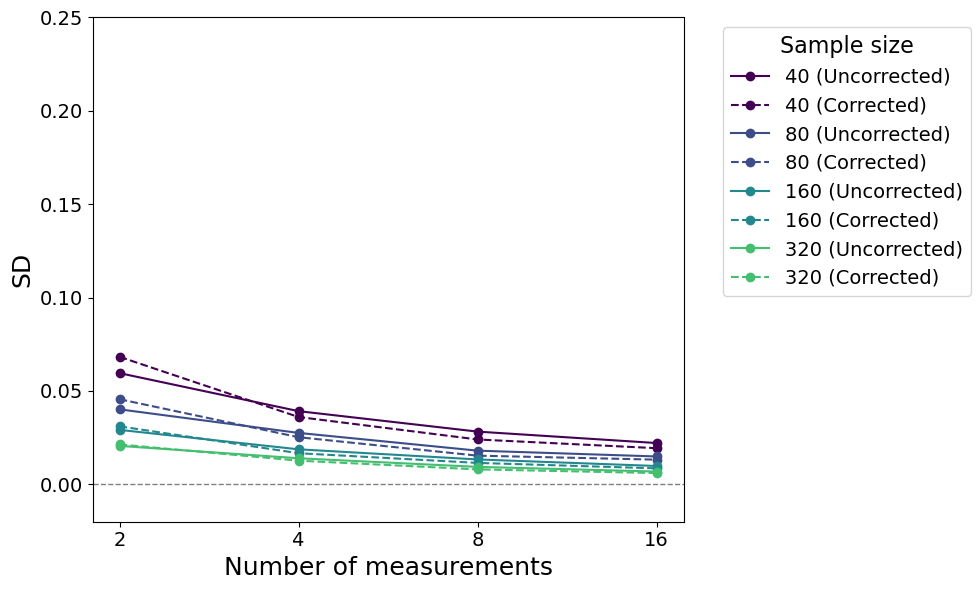

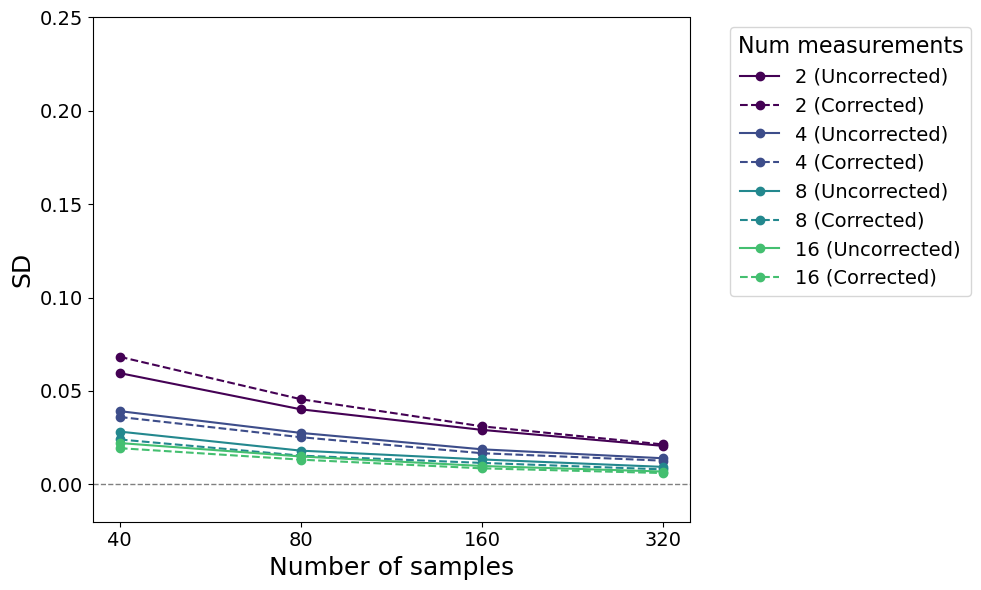

In [50]:
crowding_param = def_variable_parameters(betweenVar=0.044, withinVar=0.012, mean=-0.426,learning_factor=0.06)
rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)

for ii in [2,3,4]:
    results_corr_df = run_simulation(crowding_param, rsvp_param, true_correlation = rVals[ii])
    plot_sim_results(results_corr_df)

In [76]:
crowding_param = def_variable_parameters(betweenVar=0.044, withinVar=0.012, mean=-0.426,learning_factor=0.06)
rsvp_param = def_variable_parameters(betweenVar=0.029, withinVar=0.015, mean=2.96,learning_factor=0)

rmse_measured_mtx = np.full(n_rVals, np.nan)
rmse_corrected_mtx = np.full(n_rVals, np.nan)
sd_measured_mtx = np.full(n_rVals, np.nan)
sd_corrected_mtx = np.full(n_rVals, np.nan)
meandiff_measured_mtx = np.full(n_rVals, np.nan)
meandiff_corrected_mtx = np.full(n_rVals, np.nan)

for ii in range(n_rVals):
    
    r_Val = rVals[ii]
    print(f'r_Val = {r_Val}')

    results_corr = run_simulation(crowding_param, rsvp_param, range_samples=[320], range_measurements=[2], true_correlation = rVals[ii])
    results_corr_df = results_corr[0]

    rmse_measured_mtx[ii] = results_corr_df['rmse_measured'].iloc[0]
    rmse_corrected_mtx[ii] = results_corr_df['rmse_corrected'].iloc[0]

    sd_measured_mtx[ii] = results_corr_df['sd_measured'].iloc[0]
    sd_corrected_mtx[ii] = results_corr_df['sd_corrected'].iloc[0]

    meandiff_measured_mtx[ii] = results_corr_df['meanDiff_measured'].iloc[0]
    meandiff_corrected_mtx[ii] = results_corr_df['meanDiff_corrected'].iloc[0]

r_Val = -0.06
done with n_samples = 320
r_Val = -0.12
done with n_samples = 320
r_Val = -0.24
done with n_samples = 320
r_Val = -0.48
done with n_samples = 320
r_Val = -0.96
done with n_samples = 320


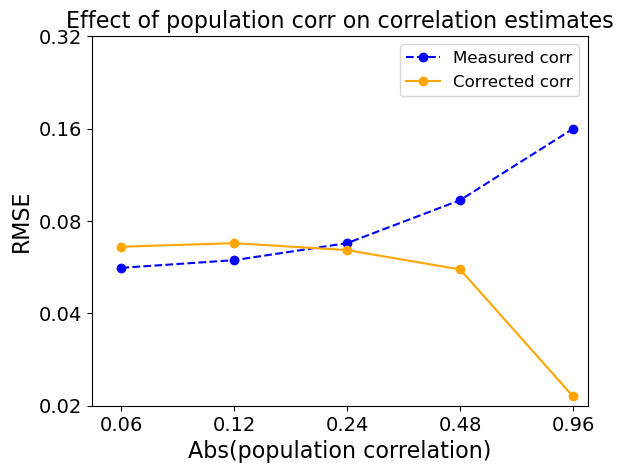

In [78]:
plt.figure()
plt.plot(abs(rVals),rmse_measured_mtx, 'o--', color='blue', label='Measured corr')
plt.plot(abs(rVals),rmse_corrected_mtx, 'o-', color='orange', label='Corrected corr')

# Formatting
plt.title('Effect of population corr on correlation estimates', fontsize=16)
plt.legend(fontsize='large')

plt.xlabel('Abs(population correlation)', fontsize=16)
plt.xscale('log')
plt.xticks(abs(rVals), size=14)
plt.xlim([0.05,1.05])
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('RMSE', fontsize=16)
plt.yscale('log')
ylims = [0.02, 0.32]
plt.ylim(ylims)
n_ticks = 5
y_ticks = np.array([ylims[0] * (2 ** ii) for ii in range(n_ticks)])
plt.yticks(y_ticks, size=14)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.show()

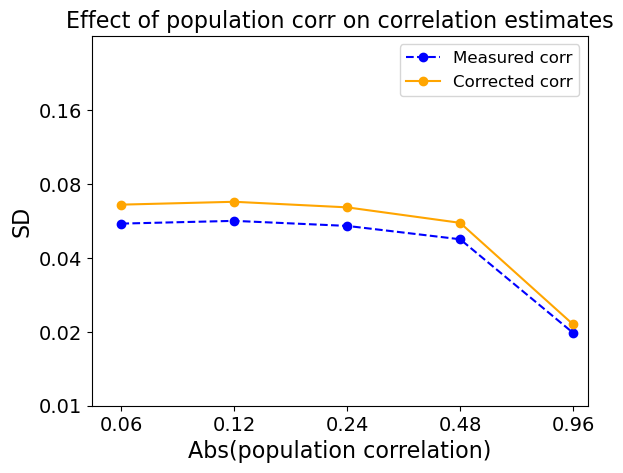

In [79]:
plt.figure()
plt.plot(abs(rVals),sd_measured_mtx, 'o--', color='blue', label='Measured corr')
plt.plot(abs(rVals),sd_corrected_mtx, 'o-', color='orange', label='Corrected corr')

# Formatting
plt.title('Effect of population corr on correlation estimates', fontsize=16)
plt.legend(fontsize='large')

plt.xlabel('Abs(population correlation)', fontsize=16)
plt.xscale('log')
plt.xticks(abs(rVals), size=14)
plt.xlim([0.05,1.05])
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('SD', fontsize=16)
plt.yscale('log')
ylims = [0.01, 0.32]
plt.ylim(ylims)
n_ticks = 5
y_ticks = np.array([ylims[0] * (2 ** ii) for ii in range(n_ticks)])
plt.yticks(y_ticks, size=14)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.show()

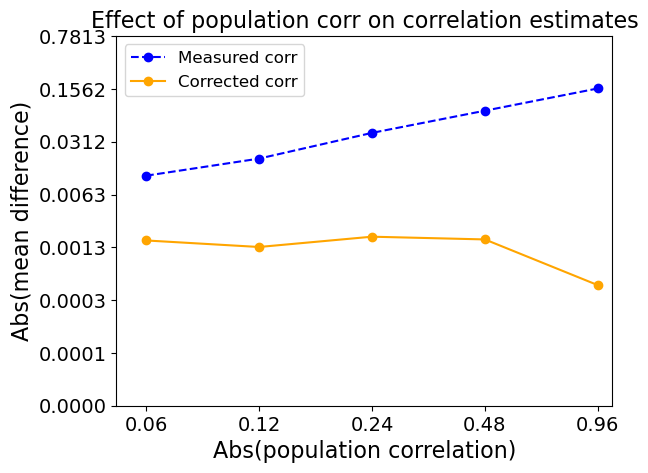

In [80]:
plt.figure()
plt.plot(abs(rVals),abs(meandiff_measured_mtx), 'o--', color='blue', label='Measured corr')
plt.plot(abs(rVals),abs(meandiff_corrected_mtx), 'o-', color='orange', label='Corrected corr')

# Formatting
plt.title('Effect of population corr on correlation estimates', fontsize=16)
plt.legend(fontsize='large')

plt.xlabel('Abs(population correlation)', fontsize=16)
plt.xscale('log')
plt.xticks(abs(rVals), size=14)
plt.xlim([0.05,1.05])
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('Abs(mean difference)', fontsize=16)
plt.yscale('log')
ylims = [0.00001, 0.32]
plt.ylim(ylims)
n_ticks = 8
y_ticks = np.array([ylims[0] * (5 ** ii) for ii in range(n_ticks)])
plt.yticks(y_ticks, size=14)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_useOffset(True)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.show()